# Modeling Notebook

In [23]:
# Import the required libraries
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

np.random.seed(42)


In [20]:
# Any Function Definitions Go HERE

def get_train_test_datasets(dfs, col_names, train_frac, test_frac):
    # Get train and test datasets, consisting of ids, tweet text, and sentiment
    train_dataset = pd.DataFrame()
    test_dataset = pd.DataFrame()
    for df in dfs:
        train_dataset = train_dataset.append(get_random_sample(df, train_frac)[col_names], ignore_index = True)
        test_dataset = test_dataset.append(get_random_sample(df, test_frac)[col_names], ignore_index = True)
    return train_dataset, test_dataset


def get_random_sample(df_to_use, frac_to_use):
    # Randomly select a specified fraction of the total number of rows.
    return df_to_use.sample(frac=frac_to_use)  # ex: df.sample(frac=0.50)


def get_stopwords_list():
    # Get English stopwords, punctuation, and 'empty text' signifiers (like empty quotes and ...)
    eng_stopwords = stopwords.words('english')
    punct = list(string.punctuation)
    empties = ["''", '""', '...', '``']
    return eng_stopwords + punct + empties


def process_tweet_text(tweet, stopwards_list):
    #tokenize, lowercase each token, remove stopwords
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed



In [9]:
# read in the processed data
pos_tweets = pd.read_csv('../data/cleaned_tweets_positive.csv')
print(pos_tweets.shape)
display(pos_tweets.head(1))

neg_tweets = pd.read_csv('../data/cleaned_tweets_negative.csv')
print(neg_tweets.shape)
display(neg_tweets.head(1))

(2861, 7)


,id,tweet_text,labeled_brand_or_product,detected_emotion,sentiment,brand,tweet_char_count
0,1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Positive,Apple,139


(544, 7)


,id,tweet_text,labeled_brand_or_product,detected_emotion,sentiment,brand,tweet_char_count
0,0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Negative,Apple,127


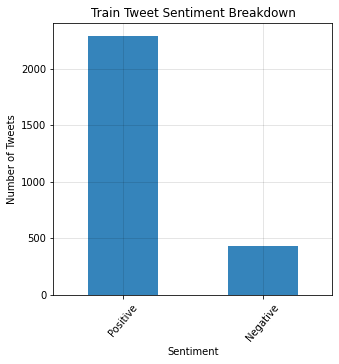

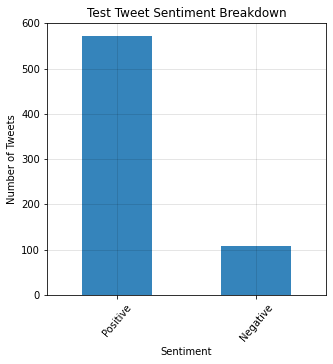

In [40]:
train_df, test_df = get_train_test_datasets([pos_tweets, neg_tweets], ['id', 'tweet_text', 'sentiment'], 0.8, 0.2)

train_by_sentiment = train_df.groupby(['sentiment'])['tweet_text'].count()
train_by_sentiment.sort_values(ascending=False, inplace=True)
train_by_sentiment.plot.bar(fontsize=10, rot=50, alpha = 0.90, figsize=(5,5),  title='Train Tweet Sentiment Breakdown')
plt.grid(color = 'black', alpha = 0.1, linestyle = '-', linewidth = 1)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()


test_by_sentiment = test_df.groupby(['sentiment'])['tweet_text'].count()
test_by_sentiment.sort_values(ascending=False, inplace=True)
test_by_sentiment.plot.bar(fontsize=10, rot=50, alpha = 0.90, figsize=(5,5),  title='Test Tweet Sentiment Breakdown')
plt.grid(color = 'black', alpha = 0.1, linestyle = '-', linewidth = 1)
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

In [ ]:
##
# - Create TRAIN and TEST data sets from the Postive and Negative Tweet datasets.
# - Separate the data (tweet_text) and the labels (sentiment) in both TRAIN and TEST
# - Process the TRAIN tweets
# - Explore TRAIN data with Freq Dist
# - Vectorize TRAIN with sklearn
# - Create a basic model (try MultinomialNB and RandomForestClassifier )
# - Fit each to our vectorized training data
# - Create predictions for TRAIN and TEST sets
# - Calculate the accuracy_score() for both TRAIN and TEST 
# - Experiment with model tuning AND/OR other model choices
#
# TODO decide the best peformance measure, accuracy or precision. What makes sense from a business POV?

In [38]:
# Train
train_data = train_df['tweet_text']
train_target = train_df['sentiment']
label_names = train_target.unique()
# TEST
test_data = test_df['tweet_text']
test_target = test_df['sentiment']

#label_names, train_data, train_target
#test_data, test_target
